In [ ]:
!uv sync

## CUDA Testing

In [1]:
# save as test_cuda.py and run: python3 test_cuda.py

import platform

print("=== Environment ===")
print("Platform:", platform.platform())
print("Python:", platform.python_version())

try:
    import torch
except ImportError as e:
    print("\nPyTorch is not installed or not in this Python environment.")
    raise SystemExit(e)

print("\n=== PyTorch / CUDA Info ===")
print("torch.__version__:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)

cuda_available = torch.cuda.is_available()
print("torch.cuda.is_available():", cuda_available)

if not cuda_available:
    print("\nCUDA is NOT available to PyTorch in this environment.")
else:
    # Number of devices
    device_count = torch.cuda.device_count()
    print("torch.cuda.device_count():", device_count)

    for i in range(device_count):
        print(f"  device {i}: {torch.cuda.get_device_name(i)}")

    # Simple tensor test on GPU
    try:
        x = torch.rand(3, 3, device="cuda")
        y = torch.rand(3, 3, device="cuda")
        z = x @ y
        print("\nSuccessfully ran a matrix multiply on CUDA.")
        print("z.device:", z.device)
    except Exception as e:
        print("\nERROR: Allocation or compute on CUDA failed:")
        print(e)

print("\n=== Test Complete ===")

=== Environment ===
Platform: Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.31
Python: 3.12.11

=== PyTorch / CUDA Info ===
torch.__version__: 2.9.1+cu128
torch.version.cuda: 12.8
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
  device 0: NVIDIA GeForce RTX 5080

=== PyTorch / CUDA Info ===
torch.__version__: 2.9.1+cu128
torch.version.cuda: 12.8
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
  device 0: NVIDIA GeForce RTX 5080

Successfully ran a matrix multiply on CUDA.
z.device: cuda:0

=== Test Complete ===

Successfully ran a matrix multiply on CUDA.
z.device: cuda:0

=== Test Complete ===


In [1]:
import torch
import numpy as np

print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

2.9.1+cu128
12.8
91002


In [ ]:
# alternate dependencies for running on mac without CUDA (only run if previous block fails)

!pip install pydantic
!pip install PyYAML
!pip install numpy==1.26.4
!pip install torch==2.1.1 torchdata==0.7.1
!pip install dgl -f https://data.dgl.ai/wheels/repo.html

import torch
import dgl

## Dataset Loading

In [2]:
import pandas as pd
from pathlib import Path

# Path to the small transactions CSV (relative to this notebook).
DATA_PATH = Path("dataset") / "HI-Small_Trans.csv"

# Load into a DataFrame
small_trans = pd.read_csv(DATA_PATH)

# Quick summary and preview
print(f"Loaded {len(small_trans)} rows; columns: {list(small_trans.columns)}")
small_trans.head()

Loaded 5078345 rows; columns: ['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


# Imbalance Visualization Overview (IBM AML Dataset)

This section adds visual summaries of the strong class imbalance (fraud vs non‑fraud) and related distributions. Run in order after the dataset has been loaded into `small_trans`.



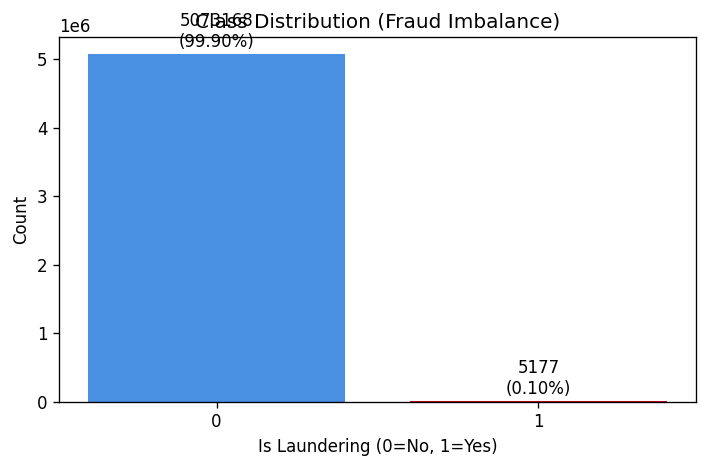

Fraud ratio: 0.0010 (0.10%)


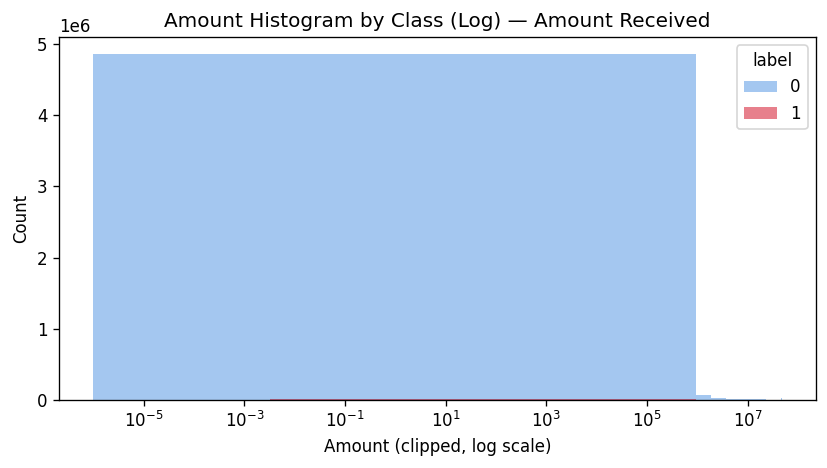

/tmp/ipykernel_1381/2201572061.py:68: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts = temp_df.set_index('ts').groupby('label').resample(freq).size().unstack(0).fillna(0)


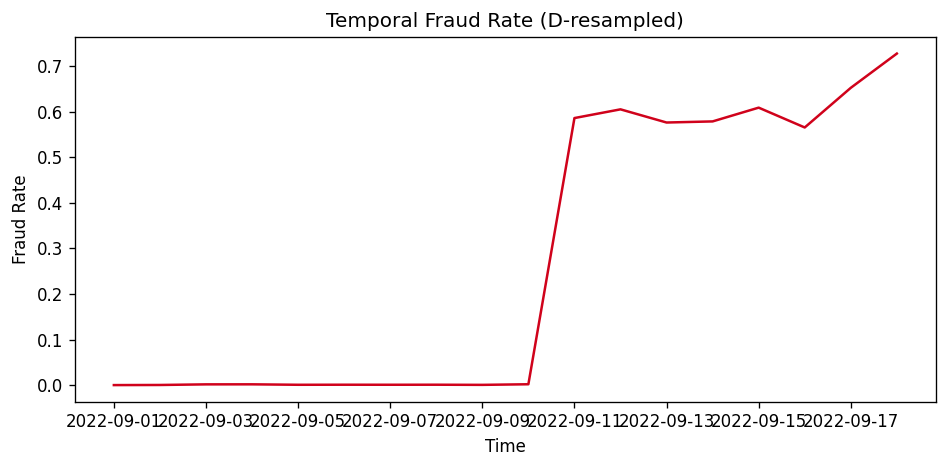

Top senders by count (column: From Bank):
 From Bank
70     449859
10      81629
12      79754
1       62211
15      52511
220     52417
20      41008
3       38413
7       31086
211     30451

Top receivers by count (column: To Bank):
 To Bank
10     42547
12     41872
15     38721
220    30625
1      30115
3      25627
7      23029
20     22048
28     21160
211    20576

Top senders by fraud count: 
 From Bank
70     633
12      76
20      67
119     59
10      51
1       50
11      47
15      46
22      40
118     36

Top receivers by fraud count: 
 To Bank
12     89
119    73
11     68
20     54
1      53
10     51
22     48
222    47
23     43
15     42


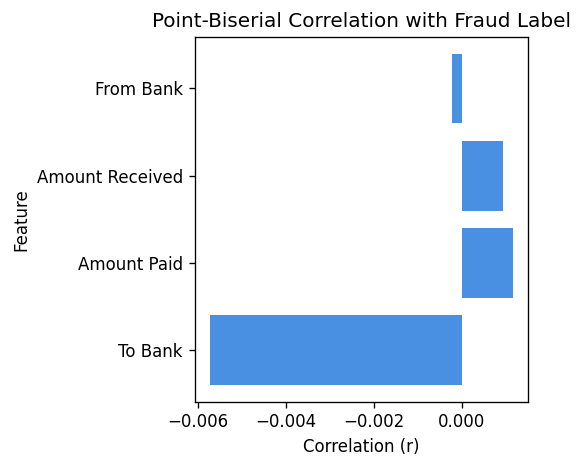

In [3]:
# Imbalance-focused visualizations for IBM AML dataset (Matplotlib-only to avoid seaborn dependency)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pointbiserialr

assert 'small_trans' in globals(), "Load the dataset into 'small_trans' first (see earlier cell)."
df = small_trans.copy()
label_col = 'Is Laundering'
if label_col not in df.columns:
    raise KeyError(f"Expected column '{label_col}' in the dataset.")

plt.rcParams.update({'figure.dpi': 120})

# 1) Class distribution (counts + percentages)
label_counts = df[label_col].value_counts().sort_index()
plt.figure(figsize=(6,4))
x = label_counts.index.astype(str).tolist()
y = label_counts.values.tolist()
bars = plt.bar(x, y, color=['#4a90e2','#d0021b'][:len(y)])
for i, v in enumerate(y):
    pct = 100 * v / sum(y)
    plt.text(i, v + max(y)*0.01, f"{v}\n({pct:.2f}%)", ha='center', va='bottom', fontsize=10)
plt.title('Class Distribution (Fraud Imbalance)')
plt.xlabel('Is Laundering (0=No, 1=Yes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
print(f"Fraud ratio: {label_counts.get(1,0)/label_counts.sum():.4f} ({label_counts.get(1,0)/label_counts.sum()*100:.2f}%)")

# 2) Amount distribution by class (log scale), if amount columns exist
amt_candidates = [c for c in df.columns if any(k in c.lower() for k in ('amount','amt','value'))]
if amt_candidates:
    amt_col = amt_candidates[0]
    amounts = pd.to_numeric(df[amt_col], errors='coerce')
    clipped = np.clip(amounts.fillna(0), 0, np.percentile(amounts.dropna(), 99.5))
    plot_df = pd.DataFrame({'amount': clipped, 'label': df[label_col]})
    plt.figure(figsize=(7,4))
    # Histograms for both classes
    bins = 50
    for lbl, clr in [(0,'#4a90e2'), (1,'#d0021b')]:
        subset = plot_df.loc[plot_df['label']==lbl, 'amount']
        plt.hist(subset, bins=bins, alpha=0.5, label=str(lbl), color=clr)
    plt.xscale('log')
    plt.legend(title='label')
    plt.title(f'Amount Histogram by Class (Log) — {amt_col}')
    plt.xlabel('Amount (clipped, log scale)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('No amount-like column found for distribution plot.')

# 3) Temporal fraud rate (auto-detect time/date column)
ts_col = None
for c in df.columns:
    cl = c.lower()
    if 'time' in cl or 'date' in cl or 'timestamp' in cl:
        ts_col = c
        break
if ts_col is not None:
    ts = pd.to_datetime(df[ts_col], errors='coerce')
    temp_df = pd.DataFrame({'ts': ts, 'label': df[label_col]})
    temp_df = temp_df.dropna(subset=['ts'])
    span_days = (temp_df['ts'].max() - temp_df['ts'].min()).days
    freq = 'D' if span_days >= 2 else 'H'
    counts = temp_df.set_index('ts').groupby('label').resample(freq).size().unstack(0).fillna(0)
    counts.columns = [f'label_{c}' for c in counts.columns]
    total = counts.sum(axis=1).replace(0, np.nan)
    fraud_rate = counts.get('label_1',0) / total
    plt.figure(figsize=(8,4))
    plt.plot(counts.index, fraud_rate, color='#d0021b')
    plt.title(f'Temporal Fraud Rate ({freq}-resampled)')
    plt.ylabel('Fraud Rate')
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()
else:
    print('No timestamp/date column detected for temporal fraud rate plot.')

# 4) Account participation imbalance (top senders/receivers if available)
sender_col = None
receiver_col = None
for c in df.columns:
    cl = c.lower()
    if sender_col is None and any(k in cl for k in ('sender','originator','from','account')):
        sender_col = c
    if receiver_col is None and any(k in cl for k in ('receiver','beneficiary','to','account.1','account_1')):
        receiver_col = c
if sender_col and receiver_col:
    part_df = df[[sender_col, receiver_col, label_col]].copy()
    top_senders = part_df.groupby(sender_col).size().sort_values(ascending=False).head(10)
    top_receivers = part_df.groupby(receiver_col).size().sort_values(ascending=False).head(10)
    fraud_senders = part_df.groupby(sender_col)[label_col].sum().sort_values(ascending=False).head(10)
    fraud_receivers = part_df.groupby(receiver_col)[label_col].sum().sort_values(ascending=False).head(10)
    print(f"Top senders by count (column: {sender_col}):\n", top_senders.to_string())
    print()
    print(f"Top receivers by count (column: {receiver_col}):\n", top_receivers.to_string())
    print()
    print(f"Top senders by fraud count: \n", fraud_senders.to_string())
    print()
    print(f"Top receivers by fraud count: \n", fraud_receivers.to_string())
else:
    print('No clear sender/receiver columns detected for participation imbalance.')

# 5) Numeric feature correlations with fraud (point-biserial) — Matplotlib bar
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != label_col]
if num_cols:
    corrs = []
    y = df[label_col].values
    for c in num_cols:
        x = pd.to_numeric(df[c], errors='coerce').fillna(0).values
        try:
            r, p = pointbiserialr(y, x)
        except Exception:
            r, p = np.nan, np.nan
        corrs.append({'feature': c, 'r': r, 'p': p})
    corr_df = pd.DataFrame(corrs).sort_values(by='r', key=lambda s: np.abs(s), ascending=False)
    plt.figure(figsize=(min(10, 0.4*len(corr_df)+3),4))
    plt.barh(corr_df['feature'], corr_df['r'], color='#4a90e2')
    plt.title('Point-Biserial Correlation with Fraud Label')
    plt.xlabel('Correlation (r)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print('No numeric columns (besides label) for correlation analysis.')


## Dataset Pre-processing

In [5]:
# convert hex account numbers to int
hex_to_int = np.vectorize(lambda x: int(x, 16))

# create adjacency lists to represent the graph
source = hex_to_int(small_trans['Account'])
target = hex_to_int(small_trans['Account.1'])

In [11]:
from torch_geometric.data import Data
import torch
import numpy as np

# Map account IDs to a compact 0..N-1 index space to avoid huge sparse IDs
# Concatenate unique accounts from source/target and factorize
all_accounts = np.concatenate([source, target])
unique_accounts, inverse_idx = np.unique(all_accounts, return_inverse=True)
num_nodes = unique_accounts.shape[0]
# Rebuild source/target as compact indices
source_idx = inverse_idx[:source.shape[0]]
target_idx = inverse_idx[source.shape[0]:]

# Build edge_index
edge_index = torch.tensor(np.vstack([source_idx, target_idx]), dtype=torch.long)

# Create Data object
data = Data(edge_index=edge_index, num_nodes=num_nodes)
print('num_nodes:', num_nodes, 'num_edges:', edge_index.size(1))
print(data)

num_nodes: 515080 num_edges: 5078345
Data(edge_index=[2, 5078345], num_nodes=515080)


In [12]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from torch_geometric.data import Data
import torch

# extract individual edge features
time = pd.to_datetime(small_trans['Timestamp']).astype('int64') / 1e9
amount_paid = small_trans['Amount Paid'].to_numpy()
amount_received = small_trans['Amount Received'].to_numpy()

# use one-hot encoding for categorical variables
paid_enc = OneHotEncoder(sparse_output=False)
paid_currency = paid_enc.fit_transform(small_trans['Payment Currency'].to_numpy().reshape(-1, 1))

received_enc = OneHotEncoder(sparse_output=False)
received_currency = received_enc.fit_transform(small_trans['Receiving Currency'].to_numpy().reshape(-1, 1))

format_enc = OneHotEncoder(sparse_output=False)
pay_format = format_enc.fit_transform(small_trans['Payment Format'].to_numpy().reshape(-1, 1))

# combine edge features into single tensor
numeric_features = np.column_stack([time, amount_paid, amount_received])
edge_features = torch.from_numpy(np.concatenate([numeric_features, paid_currency, received_currency, pay_format], axis=1)).float()

# create edge labels
fraud_label = torch.tensor(small_trans['Is Laundering'].to_numpy(), dtype=torch.long)

# attach features and labels to PyG Data
data.edge_attr = edge_features
data.edge_label = fraud_label
print(data)

Data(edge_index=[2, 5078345], num_nodes=515080, edge_attr=[5078345, 40], edge_label=[5078345])


In [13]:
# chronological 60/20/20 split by edge index order
num_edges = data.edge_index.size(1)
train_end = int(0.6 * num_edges)
val_end = int(0.8 * num_edges)

train_mask = torch.zeros(num_edges, dtype=torch.bool)
val_mask = torch.zeros(num_edges, dtype=torch.bool)
test_mask = torch.zeros(num_edges, dtype=torch.bool)
train_mask[:train_end] = True
val_mask[train_end:val_end] = True
test_mask[val_end:] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask
print('Masks set:', train_mask.sum().item(), val_mask.sum().item(), test_mask.sum().item())

Masks set: 3047007 1015669 1015669


## Model Definition and Training

In [ ]:
# PyG GNN model and edge classification training
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Ensure data object exists with edge_index, edge_attr, edge_label, and masks
assert data is not None, 'PyG Data not constructed yet'
num_nodes = data.num_nodes
num_edges = data.edge_index.size(1)
edge_feat_dim = data.edge_attr.size(1)

# Create simple node features if none exist (e.g., degree or identity)
if getattr(data, 'x', None) is None:
    deg = torch.zeros((num_nodes, 1), dtype=torch.float)
    deg.scatter_add_(0, data.edge_index[0].view(-1,1), torch.ones((num_edges,1)))
    data.x = deg  # use degree as a simple node feature

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class EdgeClassifier(nn.Module):
    def __init__(self, node_hidden, edge_feat_dim, hidden=64, num_classes=2):
        super().__init__()
        # combine node embeddings of u and v with edge features
        self.mlp = nn.Sequential(
            nn.Linear(node_hidden*2 + edge_feat_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x, edge_index, edge_attr):
        u, v = edge_index
        h = torch.cat([x[u], x[v], edge_attr], dim=1)
        return self.mlp(h)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = nn.Sequential()  # placeholder to hold submodules
gnn = GNN(in_channels=data.x.size(1), hidden_channels=64).to(device)
clf = EdgeClassifier(node_hidden=64, edge_feat_dim=edge_feat_dim, hidden=128, num_classes=int(data.edge_label.max().item()+1)).to(device)

params = list(gnn.parameters()) + list(clf.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Move tensors to device
data = data.to(device)
train_idx = data.train_mask.nonzero(as_tuple=False).view(-1)
val_idx = data.val_mask.nonzero(as_tuple=False).view(-1)
test_idx = data.test_mask.nonzero(as_tuple=False).view(-1)

def evaluate(split_idx):
    gnn.eval(); clf.eval()
    with torch.no_grad():
        x = gnn(data.x, data.edge_index)
        logits = clf(x, data.edge_index, data.edge_attr)
        y = data.edge_label
        preds = logits.argmax(dim=1)
        correct = (preds[split_idx] == y[split_idx]).sum().item()
        total = split_idx.numel()
        return correct / max(total, 1)

epochs = 20
for epoch in range(1, epochs+1):
    gnn.train(); clf.train()
    optimizer.zero_grad()
    x = gnn(data.x, data.edge_index)
    logits = clf(x, data.edge_index, data.edge_attr)
    loss = criterion(logits[train_idx], data.edge_label[train_idx])
    loss.backward()
    optimizer.step()
    if epoch % 2 == 0 or epoch == 1:
        train_acc = evaluate(train_idx)
        val_acc = evaluate(val_idx)
        print(f'Epoch {epoch:02d} | loss {loss.item():.4f} | train_acc {train_acc:.3f} | val_acc {val_acc:.3f}')

test_acc = evaluate(test_idx)
print('Test accuracy:', round(test_acc, 3))

Epoch 01 | loss 9361119.0000 | train_acc 0.999 | val_acc 0.999
Epoch 02 | loss 6774.2803 | train_acc 0.999 | val_acc 0.999
Epoch 02 | loss 6774.2803 | train_acc 0.999 | val_acc 0.999
Epoch 04 | loss 21247.0078 | train_acc 0.999 | val_acc 0.999
Epoch 04 | loss 21247.0078 | train_acc 0.999 | val_acc 0.999
Epoch 06 | loss 30554.0254 | train_acc 0.999 | val_acc 0.999
Epoch 06 | loss 30554.0254 | train_acc 0.999 | val_acc 0.999
Epoch 08 | loss 37014.7617 | train_acc 0.999 | val_acc 0.999
Epoch 08 | loss 37014.7617 | train_acc 0.999 | val_acc 0.999
Epoch 10 | loss 41773.3672 | train_acc 0.999 | val_acc 0.999
Epoch 10 | loss 41773.3672 | train_acc 0.999 | val_acc 0.999
Epoch 12 | loss 45290.9648 | train_acc 0.999 | val_acc 0.999
Epoch 12 | loss 45290.9648 | train_acc 0.999 | val_acc 0.999
